# COLLECTING DATA

In [72]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [26]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [27]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
    
)

Found 2152 files belonging to 3 classes.


In [28]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [29]:
len(dataset), 68*32

(68, 2176)

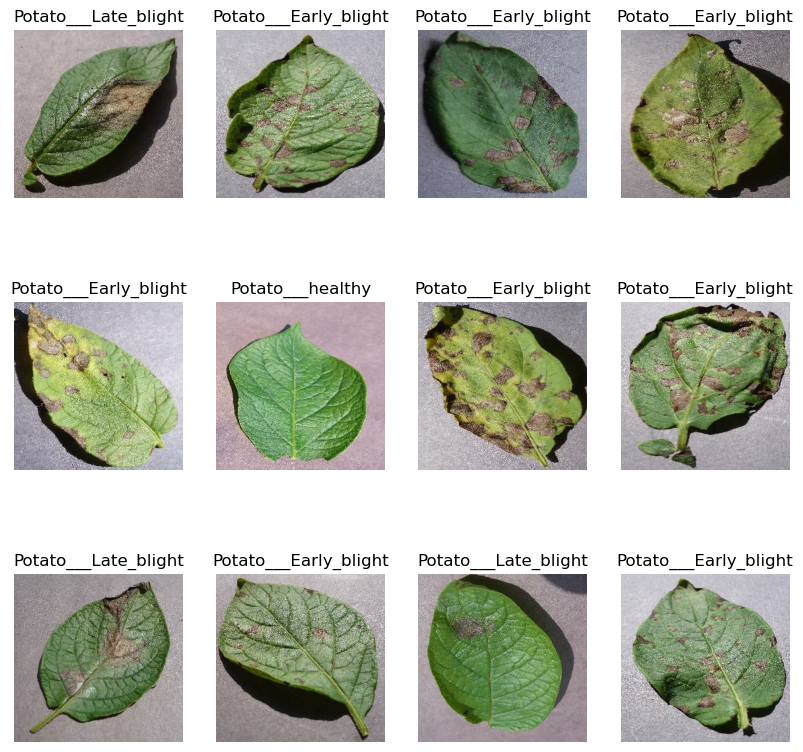

In [30]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [31]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [32]:
train_ds = dataset.take(54)
len(train_ds)

54

In [33]:
test_ds = dataset.skip(54) 
len(test_ds)

14

In [34]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [35]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [36]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [37]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
         
    train_size = int(train_split*ds_size)
    
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds =ds.skip(train_size).take(val_size)
    val_ds =ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [39]:
len(train_ds)

54

In [40]:
len(val_ds)

8

In [41]:
len(test_ds)

8

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)    
])

In [44]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)   
])

# MODEL BUILDING

In [45]:
from tensorflow.keras import layers, models

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Define the model
model = models.Sequential()

# Preprocessing layers
model.add(resize_and_rescale)
model.add(data_augmentation)

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

model.build(input_shape=(None, *input_shape))
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
54/54 [==============================] - 212s 4s/step - loss: 0.8517 - accuracy: 0.5527 - val_loss: 0.6864 - val_accuracy: 0.7413
Epoch 2/5
54/54 [==============================] - 213s 4s/step - loss: 0.5481 - accuracy: 0.8084 - val_loss: 0.6549 - val_accuracy: 0.7535
Epoch 3/5
54/54 [==============================] - 202s 4s/step - loss: 0.4732 - accuracy: 0.8304 - val_loss: 0.4060 - val_accuracy: 0.8414
Epoch 4/5
54/54 [==============================] - 184s 3s/step - loss: 0.3578 - accuracy: 0.8628 - val_loss: 0.3831 - val_accuracy: 0.8223
Epoch 5/5
54/54 [==============================] - 180s 3s/step - loss: 0.2732 - accuracy: 0.8877 - val_loss: 0.3289 - val_accuracy: 0.8779


In [49]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [56]:
acc = history.history['accuracy']
vall_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss'] 

Text(0.5, 1.0, 'Training and Validation Accuracy')

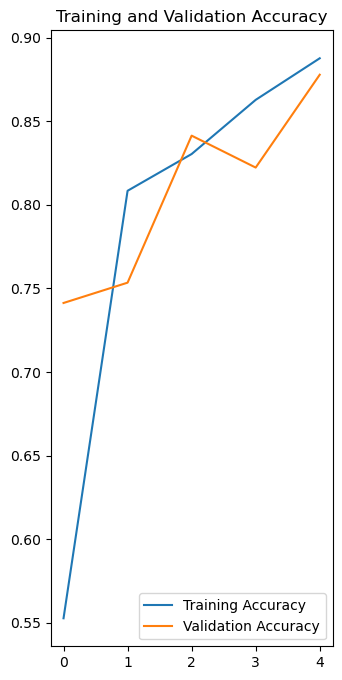

In [60]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), vall_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

First image to predict
Actual Label: Potato___Late_blight
1/1 [==============================] - 1s 618ms/step
Predicted Label: Potato___Late_blight


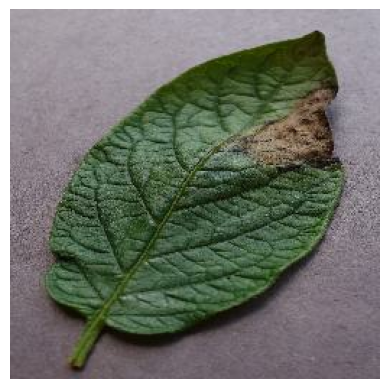

In [79]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("Actual Label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [89]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 45ms/step


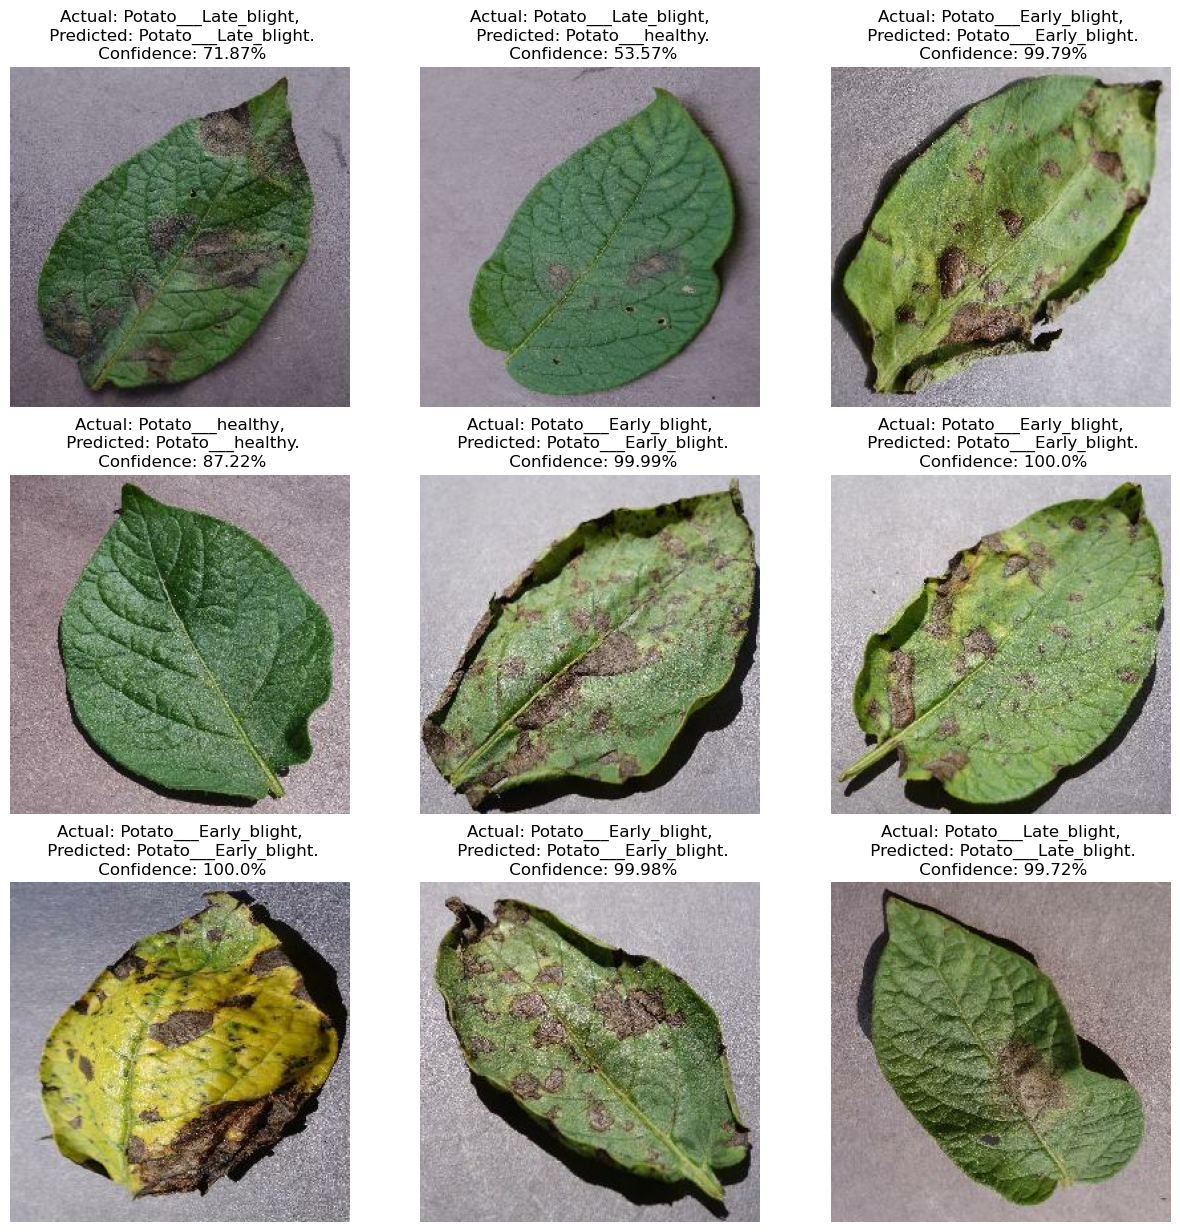

In [94]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.axis("off")
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        

In [101]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
